#

# Peer-induced fairness framework for algorithmic bias auditing 
### -- resample datasets to check the stability and universality of our framework under the data scarcity and imbalance issues

###

* Example: sensitive attribute = firm's size, we treat micro-firms as protected group and non-micro firms as non-protected group
* Data: we collect data from UK Archive Small and Medium-Sized Enterprise Finance Monitor https://doi.org/10.5255/UKDA-SN-6888-26
* Peer identification threshold in this file is $0.3 \times Std_{IC}$, fitting model: logistic, prediction model: logistic

#

## Data Preprocessing

In [7]:
import sys
sys.path.append("../..")
from preprocessing import data_preprocess

import numpy as np
import pandas as pd


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import pandas as pd

# Paths to the tab data files
data_paths = [
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
    '../../../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'
]

# Combine the dataframes
df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values
df_count = pd.concat(df_list, ignore_index=True)

# Get the total number of entries
total_entries = df_count.shape[0]
print(f"The total number of entries in the combined dataset is: {total_entries}")

C:\Users\s2285280\AppData\Local\Temp\ipykernel_8404\4124027893.py:11: DtypeWarning: Columns (13,41,42,49,52,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,1907,1908,1911,1912,1913,1914,1933,1938,1939,1940,1941,1942,1943,1944,1945,1946,1963,2002,2003,2114,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124,2125,2126,2127,2128,2129,2130,2131,2132,2133,2148,2149,2150,2151,2152,2153,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2210,2215,2216,2217,2218,2219,2220,2225,2227) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(path, sep='\t') for path in data_paths]  # Assuming tab-separated values


The total number of entries in the combined dataset is: 141166


In [9]:
# Step1: Combine dataframe
# ..represents the previous layer
df_combined = data_preprocess.combine_data(['../../../datasets/SMEs_F/raw/sme_finance_monitor_q4_2012-q1_2015_data.tab',
                                            '../../../datasets/SMEs_F/raw/sme_finance_monitor_q3_2015_q4_2017.tab',
                                            '../../../datasets/SMEs_F/raw/sme_finance_monitor_q1_2018-q2_2020.tab'],
                                            ['../../../datasets/SMEs_F/selection/selectedfeatures1.csv',
                                             '../../../datasets/SMEs_F/selection/selectedfeatures2.csv',
                                             '../../../datasets/SMEs_F/selection/selectedfeatures3.csv'],
                                             '../../../datasets/SMEs_F/selection/common_featuresname.csv')

In [10]:
# Step 2: Replace DK/Refused data
df_replace_dk_refused = data_preprocess.replace_dk_refused(df_combined)
# Step 3: Replace missing values in the combined data
replacena_df = data_preprocess.replace_missing_values(df_replace_dk_refused)
# Step 4: Check column-wise missing ratio and select columns with ratio <= 0.5
del_hmc_df, NAN_ratios, keep_columns = data_preprocess.check_col_missing_ratio(replacena_df, 0.5)
# Step 5: Check row-wise missing ratio and select rows with ratio < 0.2
del_hmr_df = data_preprocess.check_row_missing_ratio(del_hmc_df, 0.2)
# Step 6: Impute missing data in the selected columns
fill_df = data_preprocess.impute_missing_data(del_hmr_df)
# Step 7: Convert data to integer type
int_df = data_preprocess.convert_to_int(fill_df)
# Step 8: Remove NAN Final Outcomes
delfona_df = data_preprocess.remove_nan_final_outcomes(int_df)
# Step 9: Merge final outcomes
part_mergefo_df, all_mergefo_df = data_preprocess.merge_final_outcomes(delfona_df, int_df)
# Step 10: Merge regular and sensitve attributes
merge_df, int_merge_df = data_preprocess.merge_attributes(part_mergefo_df, all_mergefo_df)
# Step 11: Export csv and xlsx
# data_preprocess.export_csv(merge_df, int_merge_df)
# data_preprocess.export_xlsx(merge_df, int_merge_df)

C:\Users\s2285280\fairness-credit-scoring\group_imbalance\size_caplier\../..\preprocessing\data_preprocess.py:241: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != 5.0]
C:\Users\s2285280\fairness-credit-scoring\group_imbalance\size_caplier\../..\preprocessing\data_preprocess.py:242: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  delfo5_df = delfo5_df[delfona_df['final outcomes'] != '5']


#

# Resampling

In [11]:
from preprocessing import undersampling_only
from preprocessing.undersampling_only import ImbalanceDataSampler

base_count = 2400
imbalance_ratios=[0.1133, 0.1633, 0.2133, 0.2633, 0.3133, 0.3633]

sampler = ImbalanceDataSampler(merge_df, 'new size', base_count, imbalance_ratios, repeats_per_ratio=5)
adjusted_dfs, adjusted_info_dfs = sampler.generate_sampled_dataframes()
sampler.export_adjusted_dfs()

#

# (1) Imbalance level = 11.33%

## 1.1 1st experiment

5-fold Cross Validation AUC: [0.84474866 0.81281516 0.82083551 0.785233   0.83124674]
Mean AUC: 0.8189758150407694
Standard Deviation of the Mean AUC: 0.019974006853483616
Standard Error of the Mean AUC: 0.009987003426741808
5-fold Cross Validation Accuracy: [0.90833333 0.90625    0.9        0.90833333 0.90416667]
Mean Accuracy: 0.9054166666666665
Standard Deviation of the Mean Accuracy: 0.003118047822311607
Standard Error of the Mean Accuracy: 0.0015590239111558032
5-fold Cross Validation Precision: [0.91868132 0.91684902 0.90384615 0.91163793 0.90598291]
Mean Precision: 0.9113994649724295
Standard Deviation of the Mean Precision: 0.0058167255173139166
Standard Error of the Mean Precision: 0.0029083627586569583
5-fold Cross Validation Recall: [0.98352941 0.98356808 0.99295775 0.99295775 0.99530516]
Mean Recall: 0.9896636288318144
Standard Deviation of the Mean Recall: 0.005065841270971354
Standard Error of the Mean Recall: 0.002532920635485677
5-fold Cross Validation F1: [0.95       0

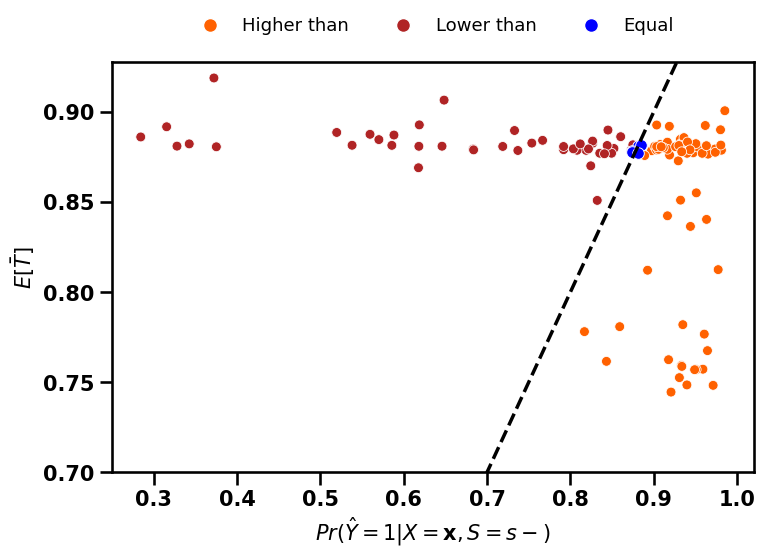

In [61]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis

# index calculation
imbalance_level_index = 0  # # the first imbalance level in the list
repeat_index = 1  # the first experiment
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_011 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']

columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_011, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_011 = analysis.full_analysis()

## 1.2 2nd experiment

5-fold Cross Validation AUC: [0.86472727 0.77369153 0.84920014 0.83655017 0.81833594]
Mean AUC: 0.8285010101010102
Standard Deviation of the Mean AUC: 0.031346427104356096
Standard Error of the Mean AUC: 0.015673213552178045
5-fold Cross Validation Accuracy: [0.90416667 0.90416667 0.90416667 0.90416667 0.89375   ]
Mean Accuracy: 0.9020833333333333
Standard Deviation of the Mean Accuracy: 0.004166666666666652
Standard Error of the Mean Accuracy: 0.002083333333333326
5-fold Cross Validation Precision: [0.90928726 0.90948276 0.91484716 0.90948276 0.90149893]
Mean Precision: 0.9089197730338118
Standard Deviation of the Mean Precision: 0.004265484874890027
Standard Error of the Mean Precision: 0.0021327424374450133
5-fold Cross Validation Recall: [0.99058824 0.99061033 0.98356808 0.99061033 0.98826291]
Mean Recall: 0.9887279756973213
Standard Deviation of the Mean Recall: 0.0027345175191694476
Standard Error of the Mean Recall: 0.0013672587595847238
5-fold Cross Validation F1: [0.9481982  0

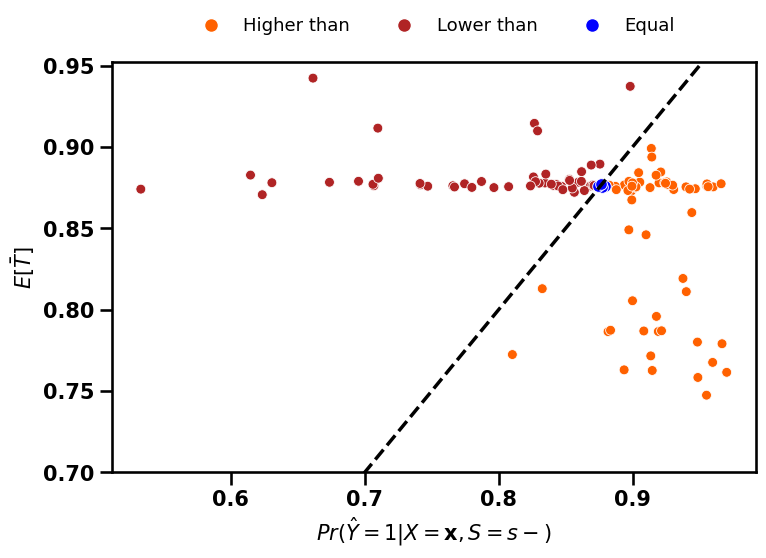

In [62]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 0  
repeat_index = 2 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_012 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_012, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_012 = analysis.full_analysis()

## 1.3 3rd experiment

5-fold Cross Validation AUC: [0.83373262 0.83083377 0.85343853 0.84078856 0.81161972]
Mean AUC: 0.8340826395223523
Standard Deviation of the Mean AUC: 0.013673920055753715
Standard Error of the Mean AUC: 0.006836960027876857
5-fold Cross Validation Accuracy: [0.9        0.90625    0.8875     0.89791667 0.89583333]
Mean Accuracy: 0.8975
Standard Deviation of the Mean Accuracy: 0.006095307849303263
Standard Error of the Mean Accuracy: 0.003047653924651631
5-fold Cross Validation Precision: [0.90191898 0.91684902 0.91333333 0.90712743 0.90692641]
Mean Precision: 0.9092310323856969
Standard Deviation of the Mean Precision: 0.005254809985882609
Standard Error of the Mean Precision: 0.0026274049929413045
5-fold Cross Validation Recall: [0.99529412 0.98356808 0.96478873 0.98591549 0.98356808]
Mean Recall: 0.9826268986467825
Standard Deviation of the Mean Recall: 0.009912064278337643
Standard Error of the Mean Recall: 0.004956032139168821
5-fold Cross Validation F1: [0.94630872 0.94903737 0.93

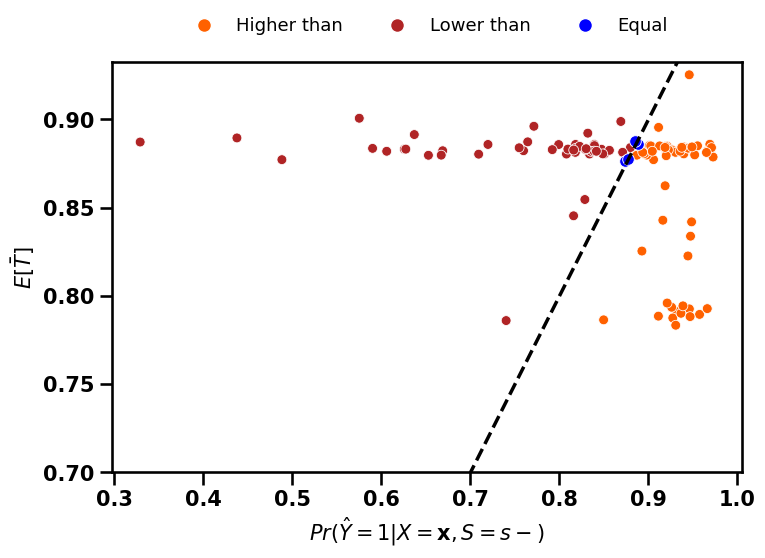

In [63]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 0  
repeat_index = 3 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_013 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_013, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_013 = analysis.full_analysis()

## 1.4 4th experiment

5-fold Cross Validation AUC: [0.8297754  0.86045905 0.79497044 0.85102591 0.85254738]
Mean AUC: 0.8377556366388733
Standard Deviation of the Mean AUC: 0.0236837416882087
Standard Error of the Mean AUC: 0.01184187084410435
5-fold Cross Validation Accuracy: [0.88541667 0.90625    0.88958333 0.89583333 0.90625   ]
Mean Accuracy: 0.8966666666666667
Standard Deviation of the Mean Accuracy: 0.008498365855987991
Standard Error of the Mean Accuracy: 0.004249182927993996
5-fold Cross Validation Precision: [0.89529915 0.90967742 0.89765458 0.91964286 0.90967742]
Mean Precision: 0.9063902850746857
Standard Deviation of the Mean Precision: 0.008905807328773444
Standard Error of the Mean Precision: 0.004452903664386722
5-fold Cross Validation Recall: [0.98588235 0.99295775 0.98826291 0.96713615 0.99295775]
Mean Recall: 0.9854393813863573
Standard Deviation of the Mean Recall: 0.009552260884792399
Standard Error of the Mean Recall: 0.0047761304423961995
5-fold Cross Validation F1: [0.93840985 0.9494

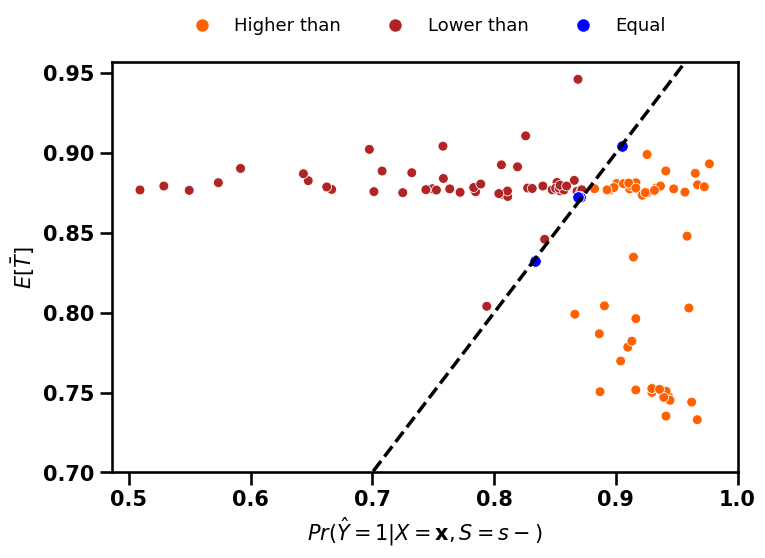

In [64]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 0  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_014 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_014, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_014 = analysis.full_analysis()

## 1.5 5th experiment

5-fold Cross Validation AUC: [0.81664171 0.82933403 0.81288037 0.79197096 0.84150583]
Mean AUC: 0.818466579074367
Standard Deviation of the Mean AUC: 0.016646092380899428
Standard Error of the Mean AUC: 0.008323046190449714
5-fold Cross Validation Accuracy: [0.89791667 0.90416667 0.89791667 0.8875     0.9       ]
Mean Accuracy: 0.8975000000000002
Standard Deviation of the Mean Accuracy: 0.005496210815947071
Standard Error of the Mean Accuracy: 0.0027481054079735354
5-fold Cross Validation Precision: [0.9017094  0.9185022  0.91796009 0.90086207 0.91266376]
Mean Precision: 0.9103395034936804
Standard Deviation of the Mean Precision: 0.007673402705521394
Standard Error of the Mean Precision: 0.0038367013527606966
5-fold Cross Validation Recall: [0.99294118 0.97887324 0.97183099 0.98122066 0.98122066]
Mean Recall: 0.9812173432753383
Standard Deviation of the Mean Recall: 0.006797746892150002
Standard Error of the Mean Recall: 0.0033988734460750005
5-fold Cross Validation F1: [0.94512878 0.

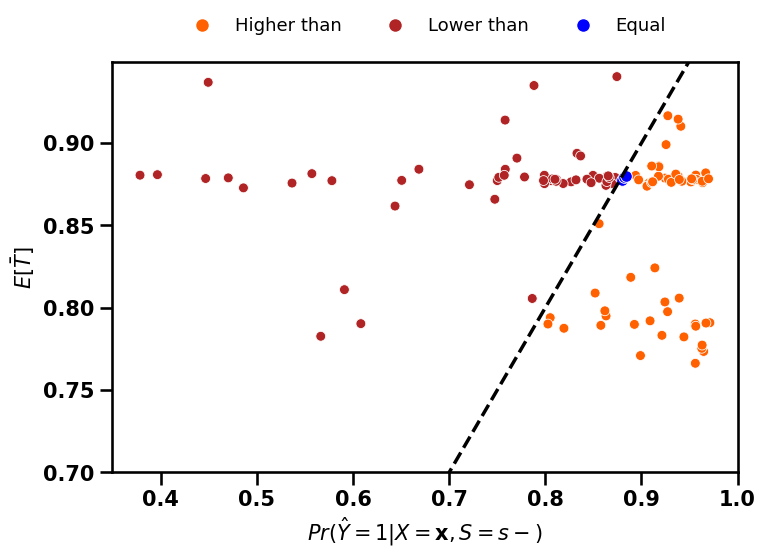

In [65]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 0  
repeat_index = 5 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_015 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_015, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_015 = analysis.full_analysis()

#

# (2) Imbalance level = 16.33%

## 2.1 1st experiment

5-fold Cross Validation AUC: [0.83320181 0.85470085 0.83491198 0.82695497 0.85698112]
Mean AUC: 0.8413501455337871
Standard Deviation of the Mean AUC: 0.01214607221612698
Standard Error of the Mean AUC: 0.00607303610806349
5-fold Cross Validation Accuracy: [0.88125    0.8875     0.86875    0.87708333 0.86666667]
Mean Accuracy: 0.87625
Standard Deviation of the Mean Accuracy: 0.0077504480157242536
Standard Error of the Mean Accuracy: 0.0038752240078621268
5-fold Cross Validation Precision: [0.89090909 0.90654206 0.87919463 0.88713318 0.88584475]
Mean Precision: 0.8899247419118064
Standard Deviation of the Mean Precision: 0.009128838931631104
Standard Error of the Mean Precision: 0.004564419465815552
5-fold Cross Validation Recall: [0.97755611 0.96517413 0.97761194 0.97761194 0.96517413]
Mean Recall: 0.9726256498058337
Standard Deviation of the Mean Recall: 0.006084175127113826
Standard Error of the Mean Recall: 0.0030420875635569127
5-fold Cross Validation F1: [0.93222354 0.93493976 0.9

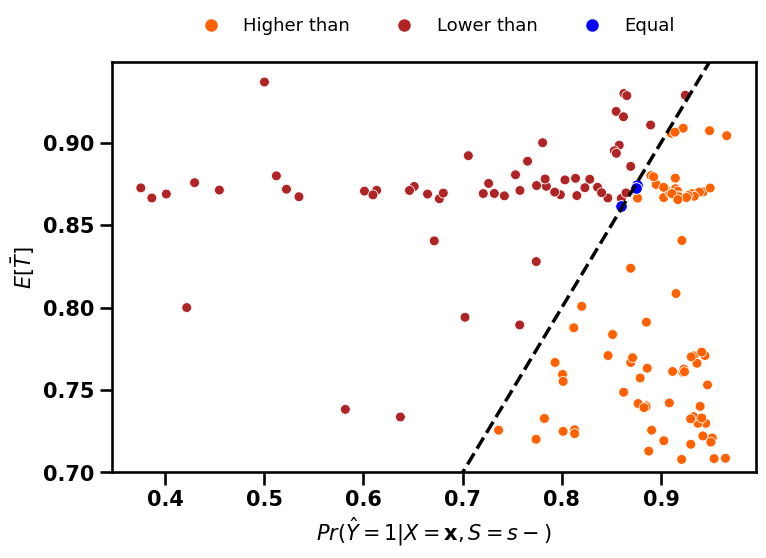

In [66]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 1  
repeat_index = 1 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_021 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_021, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_021 = analysis.full_analysis()

## 2.2 2nd experiment

5-fold Cross Validation AUC: [0.83320181 0.85470085 0.83491198 0.82695497 0.85698112]
Mean AUC: 0.8413501455337871
Standard Deviation of the Mean AUC: 0.01214607221612698
Standard Error of the Mean AUC: 0.00607303610806349
5-fold Cross Validation Accuracy: [0.88125    0.8875     0.86875    0.87708333 0.86666667]
Mean Accuracy: 0.87625
Standard Deviation of the Mean Accuracy: 0.0077504480157242536
Standard Error of the Mean Accuracy: 0.0038752240078621268
5-fold Cross Validation Precision: [0.89090909 0.90654206 0.87919463 0.88713318 0.88584475]
Mean Precision: 0.8899247419118064
Standard Deviation of the Mean Precision: 0.009128838931631104
Standard Error of the Mean Precision: 0.004564419465815552
5-fold Cross Validation Recall: [0.97755611 0.96517413 0.97761194 0.97761194 0.96517413]
Mean Recall: 0.9726256498058337
Standard Deviation of the Mean Recall: 0.006084175127113826
Standard Error of the Mean Recall: 0.0030420875635569127
5-fold Cross Validation F1: [0.93222354 0.93493976 0.9

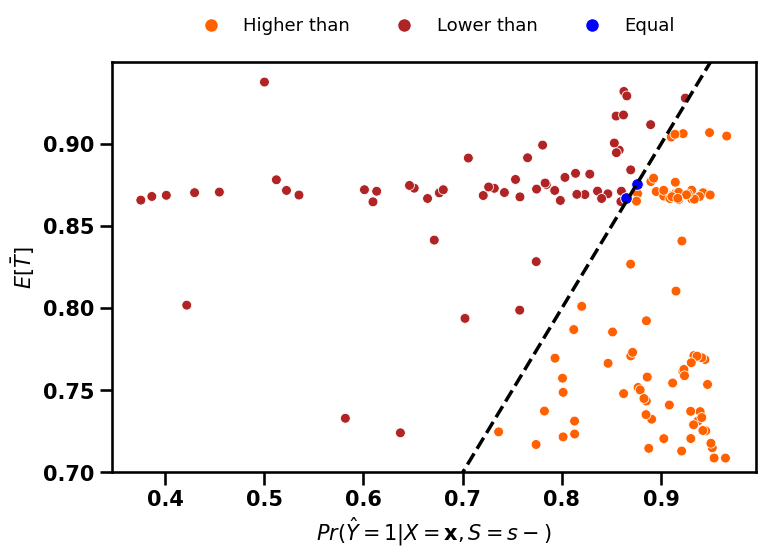

In [67]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 1  
repeat_index = 2 
index_022 = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_022 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_022, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_022 = analysis.full_analysis()

## 2.3 3rd experiment

5-fold Cross Validation AUC: [0.84945863 0.84642493 0.80606582 0.86573543 0.83193009]
Mean AUC: 0.8399229803667299
Standard Deviation of the Mean AUC: 0.020048339137855423
Standard Error of the Mean AUC: 0.010024169568927712
5-fold Cross Validation Accuracy: [0.87708333 0.87708333 0.85       0.87708333 0.86875   ]
Mean Accuracy: 0.8699999999999999
Standard Deviation of the Mean Accuracy: 0.010507933510765413
Standard Error of the Mean Accuracy: 0.005253966755382707
5-fold Cross Validation Precision: [0.88340807 0.88888889 0.86995516 0.89066059 0.8951049 ]
Mean Precision: 0.8856035209896922
Standard Deviation of the Mean Precision: 0.008675655785708166
Standard Error of the Mean Precision: 0.004337827892854082
5-fold Cross Validation Recall: [0.98254364 0.97512438 0.96517413 0.97263682 0.95522388]
Mean Recall: 0.970140568975571
Standard Deviation of the Mean Recall: 0.009296008929693164
Standard Error of the Mean Recall: 0.004648004464846581
5-fold Cross Validation F1: [0.93034238 0.930

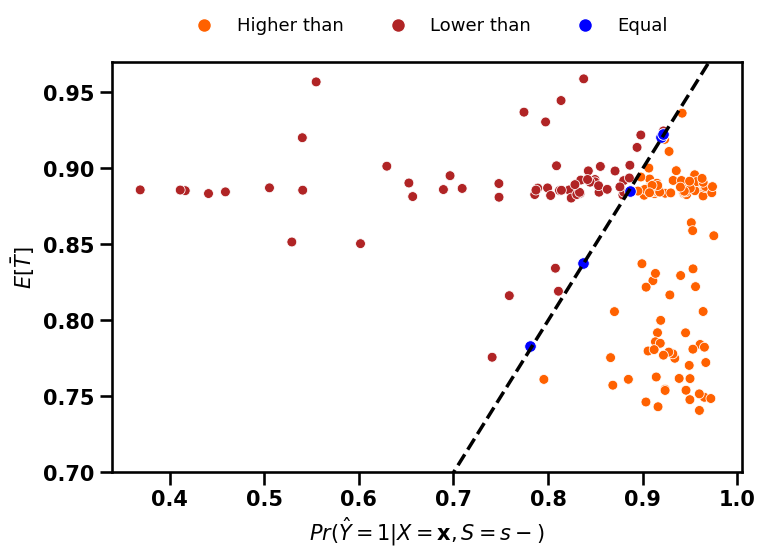

In [68]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 1  
repeat_index = 3 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_023 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_023, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_023 = analysis.full_analysis()

## 2.4 4th experiment

5-fold Cross Validation AUC: [0.84942707 0.81635094 0.80708636 0.81410256 0.80305205]
Mean AUC: 0.818003795496395
Standard Deviation of the Mean AUC: 0.016420222459029635
Standard Error of the Mean AUC: 0.008210111229514818
5-fold Cross Validation Accuracy: [0.86458333 0.86875    0.85833333 0.87083333 0.85416667]
Mean Accuracy: 0.8633333333333335
Standard Deviation of the Mean Accuracy: 0.00626387349098874
Standard Error of the Mean Accuracy: 0.00313193674549437
5-fold Cross Validation Precision: [0.87837838 0.88089888 0.87443946 0.87444934 0.87219731]
Mean Precision: 0.8760726730580739
Standard Deviation of the Mean Precision: 0.0031282439370440467
Standard Error of the Mean Precision: 0.0015641219685220231
5-fold Cross Validation Recall: [0.97256858 0.97512438 0.97014925 0.98756219 0.96766169]
Mean Recall: 0.9746132181982855
Standard Deviation of the Mean Recall: 0.006933518350497855
Standard Error of the Mean Recall: 0.003466759175248927
5-fold Cross Validation F1: [0.92307692 0.925

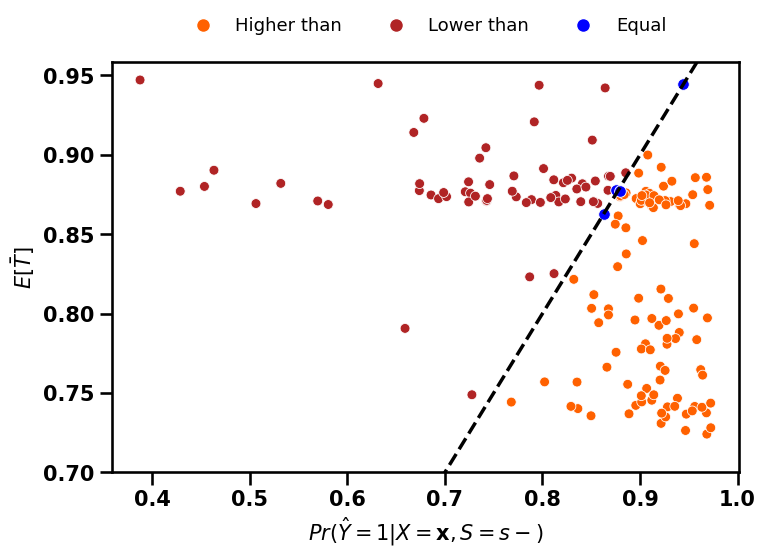

In [69]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 1  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_024 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_024, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_024 = analysis.full_analysis()

## 2.5 5th experiment

5-fold Cross Validation AUC: [0.78476278 0.81343284 0.82789578 0.8603776  0.8576349 ]
Mean AUC: 0.8288207783081853
Standard Deviation of the Mean AUC: 0.028301373133797394
Standard Error of the Mean AUC: 0.014150686566898696
5-fold Cross Validation Accuracy: [0.85833333 0.85208333 0.875      0.8625     0.87291667]
Mean Accuracy: 0.8641666666666667
Standard Deviation of the Mean Accuracy: 0.008680277773333207
Standard Error of the Mean Accuracy: 0.004340138886666603
5-fold Cross Validation Precision: [0.8758465  0.87528345 0.89583333 0.87668161 0.87637969]
Mean Precision: 0.8800049172946046
Standard Deviation of the Mean Precision: 0.007928556896242363
Standard Error of the Mean Precision: 0.0039642784481211816
5-fold Cross Validation Recall: [0.96758105 0.960199   0.96268657 0.97263682 0.98756219]
Mean Recall: 0.9701331248991949
Standard Deviation of the Mean Recall: 0.009702492530170916
Standard Error of the Mean Recall: 0.004851246265085458
5-fold Cross Validation F1: [0.91943128 0.9

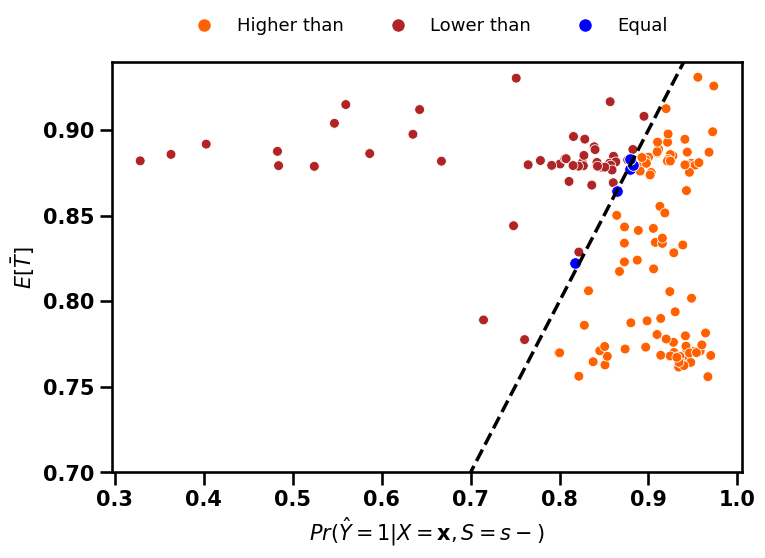

In [70]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 1  
repeat_index = 5 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_025 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race', 'establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_025, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_025 = analysis.full_analysis()

# 

# (3) Imbalance level = 21.33%

## 3.1 1st experiment

5-fold Cross Validation AUC: [0.84984935 0.83714597 0.85174811 0.82498184 0.79966802]
Mean AUC: 0.832678656652806
Standard Deviation of the Mean AUC: 0.019117409735690895
Standard Error of the Mean AUC: 0.009558704867845448
5-fold Cross Validation Accuracy: [0.8375     0.84166667 0.85833333 0.84375    0.82916667]
Mean Accuracy: 0.8420833333333334
Standard Deviation of the Mean Accuracy: 0.009537935951882964
Standard Error of the Mean Accuracy: 0.004768967975941482
5-fold Cross Validation Precision: [0.85176471 0.86298077 0.87259615 0.86157518 0.85748792]
Mean Precision: 0.8612809461324407
Standard Deviation of the Mean Precision: 0.0068695815355107916
Standard Error of the Mean Precision: 0.0034347907677553953
5-fold Cross Validation Recall: [0.9602122  0.94973545 0.96031746 0.95502646 0.93915344]
Mean Recall: 0.9528890011648633
Standard Deviation of the Mean Recall: 0.007899247170062924
Standard Error of the Mean Recall: 0.003949623585031462
5-fold Cross Validation F1: [0.90274314 0.9

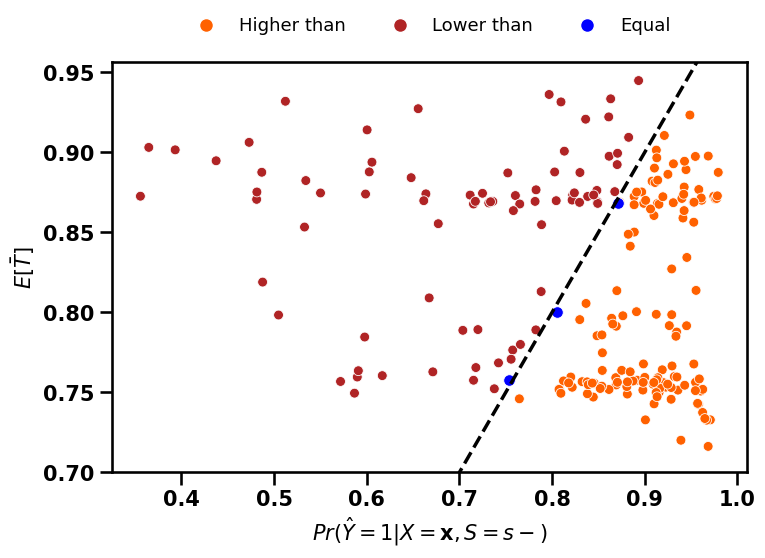

In [71]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 2  
repeat_index = 1
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_031 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race','new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_031, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_031 = analysis.full_analysis()

## 3.2 2nd experiment

5-fold Cross Validation AUC: [0.8368314  0.84858388 0.79301535 0.84506951 0.85783017]
Mean AUC: 0.8362660616540174
Standard Deviation of the Mean AUC: 0.022650312633560016
Standard Error of the Mean AUC: 0.011325156316780008
5-fold Cross Validation Accuracy: [0.85       0.83958333 0.825      0.84583333 0.86041667]
Mean Accuracy: 0.8441666666666666
Standard Deviation of the Mean Accuracy: 0.011740835669671167
Standard Error of the Mean Accuracy: 0.005870417834835584
5-fold Cross Validation Precision: [0.87654321 0.85411765 0.84507042 0.86538462 0.88395062]
Mean Precision: 0.8650133024278288
Standard Deviation of the Mean Precision: 0.014199523212975802
Standard Error of the Mean Precision: 0.0070997616064879
5-fold Cross Validation Recall: [0.94164456 0.96031746 0.95238095 0.95238095 0.94708995]
Mean Recall: 0.950762774900706
Standard Deviation of the Mean Recall: 0.006215472221214454
Standard Error of the Mean Recall: 0.0031077361106072268
5-fold Cross Validation F1: [0.90792839 0.9041

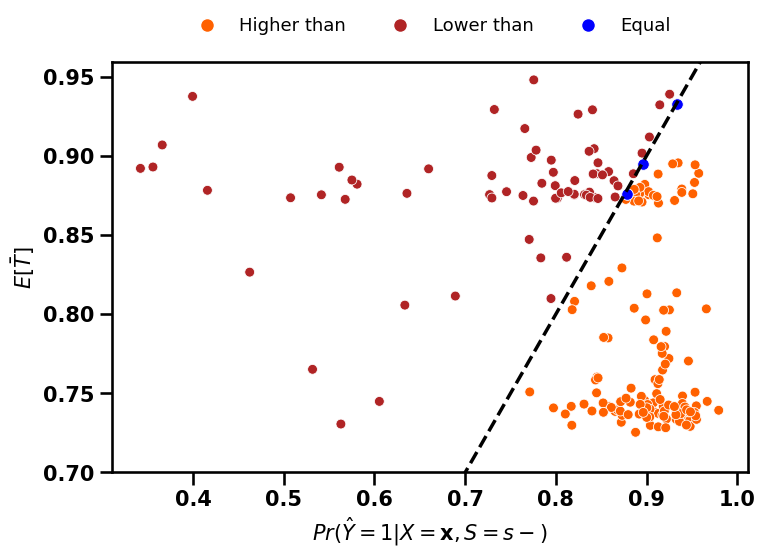

In [72]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 2  
repeat_index = 2 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_032 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_032, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_032 = analysis.full_analysis()

## 3.3 3rd experiment

5-fold Cross Validation AUC: [0.83701167 0.80078328 0.85002334 0.87711381 0.86304337]
Mean AUC: 0.8455950917723174
Standard Deviation of the Mean AUC: 0.026073953181548436
Standard Error of the Mean AUC: 0.013036976590774218
5-fold Cross Validation Accuracy: [0.83333333 0.83125    0.83125    0.85       0.87083333]
Mean Accuracy: 0.8433333333333334
Standard Deviation of the Mean Accuracy: 0.015444794160708849
Standard Error of the Mean Accuracy: 0.007722397080354425
5-fold Cross Validation Precision: [0.85273159 0.85273159 0.84777518 0.86778846 0.87980769]
Mean Precision: 0.8601669024776089
Standard Deviation of the Mean Precision: 0.011899339324281949
Standard Error of the Mean Precision: 0.0059496696621409734
5-fold Cross Validation Recall: [0.95225464 0.94973545 0.95767196 0.95502646 0.96825397]
Mean Recall: 0.956588494519529
Standard Deviation of the Mean Recall: 0.00641004896213456
Standard Error of the Mean Recall: 0.00320502448106728
5-fold Cross Validation F1: [0.89974937 0.8986

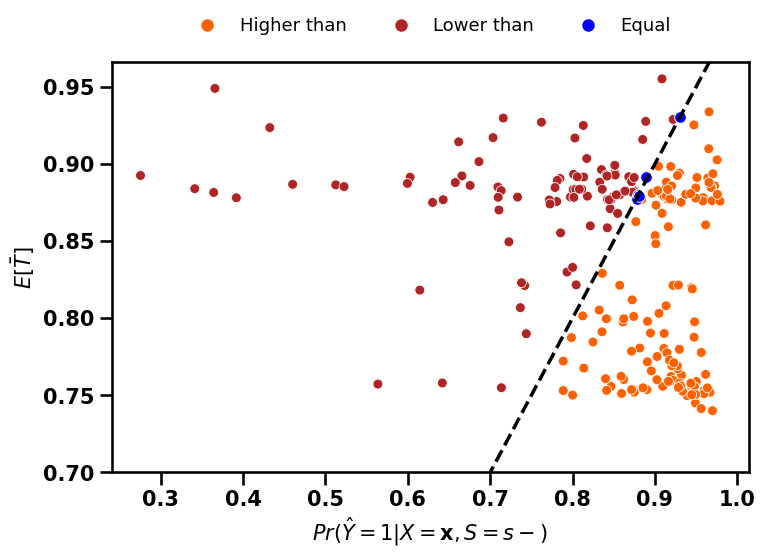

In [73]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 2  
repeat_index = 3 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_033 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_033, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_033 = analysis.full_analysis()

# 3.4 4th experiment

5-fold Cross Validation AUC: [0.88963715 0.85017896 0.85609244 0.83903932 0.82290694]
Mean AUC: 0.8515709606025812
Standard Deviation of the Mean AUC: 0.0221363227634293
Standard Error of the Mean AUC: 0.011068161381714648
5-fold Cross Validation Accuracy: [0.85208333 0.83958333 0.85208333 0.84166667 0.82708333]
Mean Accuracy: 0.8425
Standard Deviation of the Mean Accuracy: 0.009279607271383373
Standard Error of the Mean Accuracy: 0.004639803635691686
5-fold Cross Validation Precision: [0.88059701 0.86797066 0.87901235 0.86124402 0.85202864]
Mean Precision: 0.8681705359015959
Standard Deviation of the Mean Precision: 0.010775338700822836
Standard Error of the Mean Precision: 0.005387669350411418
5-fold Cross Validation Recall: [0.93899204 0.93915344 0.94179894 0.95238095 0.94444444]
Mean Recall: 0.9433539640436193
Standard Deviation of the Mean Recall: 0.004934866351883074
Standard Error of the Mean Recall: 0.0024674331759415367
5-fold Cross Validation F1: [0.90885751 0.9021601  0.9093

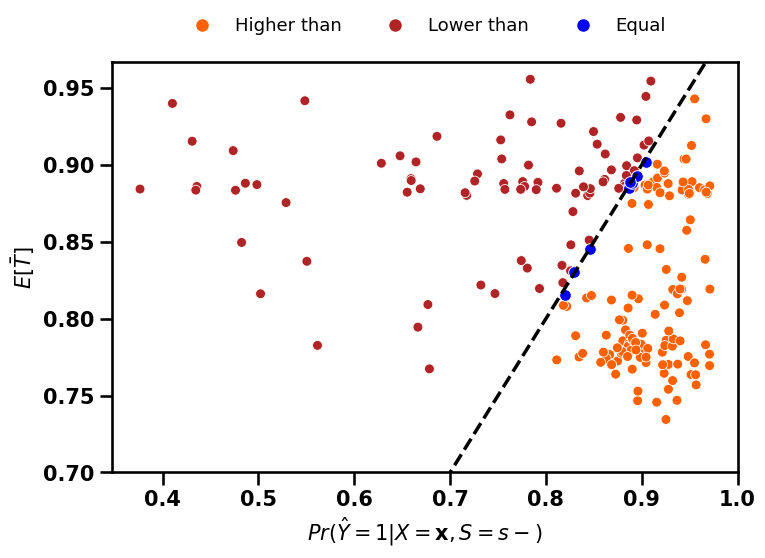

In [74]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 2  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_034 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_034, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_034 = analysis.full_analysis()

## 3.5 5th experiment

5-fold Cross Validation AUC: [0.84303778 0.81781046 0.85486046 0.84329287 0.82268648]
Mean AUC: 0.8363376108037615
Standard Deviation of the Mean AUC: 0.01389944381820936
Standard Error of the Mean AUC: 0.00694972190910468
5-fold Cross Validation Accuracy: [0.82916667 0.83125    0.8625     0.85208333 0.82708333]
Mean Accuracy: 0.8404166666666667
Standard Deviation of the Mean Accuracy: 0.014227809232469898
Standard Error of the Mean Accuracy: 0.007113904616234949
5-fold Cross Validation Precision: [0.86419753 0.85441527 0.875      0.86460808 0.85371703]
Mean Precision: 0.8623875815431206
Standard Deviation of the Mean Precision: 0.007823245088670034
Standard Error of the Mean Precision: 0.003911622544335016
5-fold Cross Validation Recall: [0.92838196 0.94708995 0.96296296 0.96296296 0.94179894]
Mean Recall: 0.9486393555359072
Standard Deviation of the Mean Recall: 0.013190036724048166
Standard Error of the Mean Recall: 0.006595018362024083
5-fold Cross Validation F1: [0.89514066 0.8983

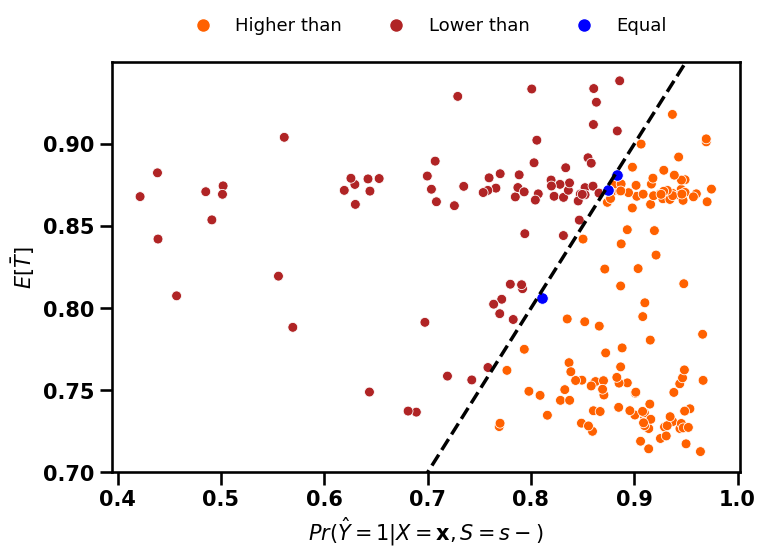

In [75]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 2  
repeat_index = 5 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_035 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_035, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_035 = analysis.full_analysis()

# 

# (4) Imbalance level = 26.33%

## 4.1 1st experiment

5-fold Cross Validation AUC: [0.84325578 0.84772666 0.83880369 0.81744911 0.85147072]
Mean AUC: 0.839741193333772
Standard Deviation of the Mean AUC: 0.011929105763774222
Standard Error of the Mean AUC: 0.00596455288188711
5-fold Cross Validation Accuracy: [0.80416667 0.8375     0.825      0.82708333 0.82083333]
Mean Accuracy: 0.8229166666666667
Standard Deviation of the Mean Accuracy: 0.010865337342004405
Standard Error of the Mean Accuracy: 0.0054326686710022025
5-fold Cross Validation Precision: [0.82294264 0.8556701  0.8375     0.85564304 0.83168317]
Mean Precision: 0.8406877918841118
Standard Deviation of the Mean Precision: 0.013071073339549611
Standard Error of the Mean Precision: 0.006535536669774805
5-fold Cross Validation Recall: [0.93484419 0.93785311 0.94632768 0.92090395 0.94915254]
Mean Recall: 0.9378162961540308
Standard Deviation of the Mean Recall: 0.009958074505165284
Standard Error of the Mean Recall: 0.004979037252582642
5-fold Cross Validation F1: [0.87533156 0.894

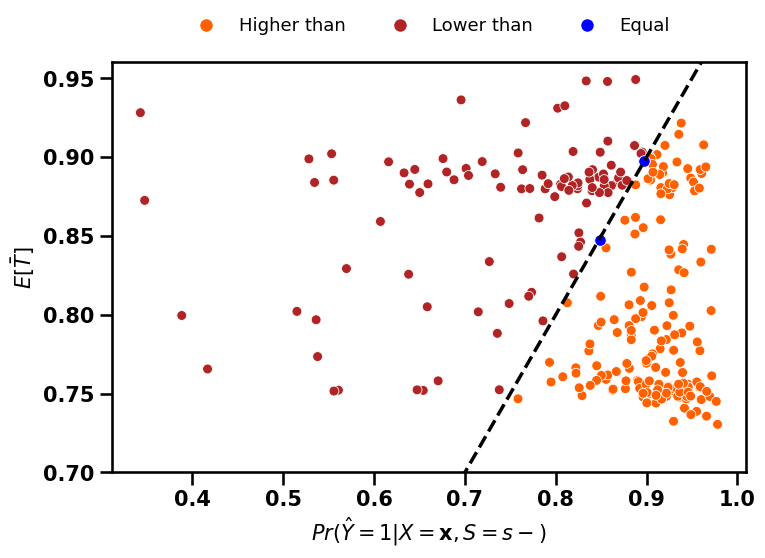

In [76]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 3  
repeat_index = 1 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_041 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_041, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_041 = analysis.full_analysis()

## 4.2 2nd experiment

5-fold Cross Validation AUC: [0.7968147  0.81910815 0.83323245 0.8287037  0.82276253]
Mean AUC: 0.8201243075157689
Standard Deviation of the Mean AUC: 0.01262346810882058
Standard Error of the Mean AUC: 0.00631173405441029
5-fold Cross Validation Accuracy: [0.80833333 0.80833333 0.81041667 0.8125     0.80416667]
Mean Accuracy: 0.8087500000000001
Standard Deviation of the Mean Accuracy: 0.0027638539919628232
Standard Error of the Mean Accuracy: 0.0013819269959814116
5-fold Cross Validation Precision: [0.82543641 0.82587065 0.82309582 0.83333333 0.82828283]
Mean Precision: 0.827203808091142
Standard Deviation of the Mean Precision: 0.0034788481925948087
Standard Error of the Mean Precision: 0.0017394240962974043
5-fold Cross Validation Recall: [0.93767705 0.93785311 0.94632768 0.93220339 0.92655367]
Mean Recall: 0.9361229813863414
Standard Deviation of the Mean Recall: 0.006579958945273178
Standard Error of the Mean Recall: 0.003289979472636589
5-fold Cross Validation F1: [0.87798408 0.8

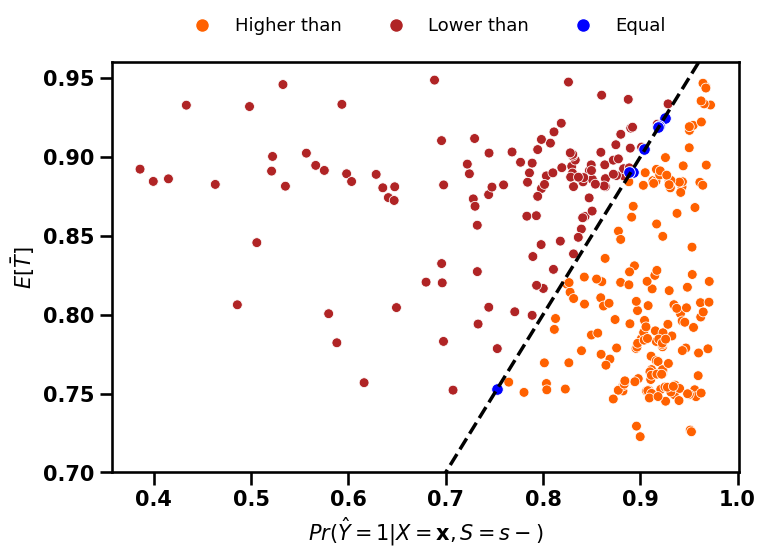

In [77]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 3  
repeat_index = 2 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_042 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_042, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_042 = analysis.full_analysis()

## 4.3 3rd experiment

5-fold Cross Validation AUC: [0.80859227 0.83215631 0.81956775 0.84911667 0.83992467]
Mean AUC: 0.8298715341897382
Standard Deviation of the Mean AUC: 0.014391915163191434
Standard Error of the Mean AUC: 0.007195957581595716
5-fold Cross Validation Accuracy: [0.82083333 0.82291667 0.80416667 0.84166667 0.82291667]
Mean Accuracy: 0.8225
Standard Deviation of the Mean Accuracy: 0.011887785514739247
Standard Error of the Mean Accuracy: 0.005943892757369624
5-fold Cross Validation Precision: [0.85224274 0.8337469  0.825      0.86387435 0.83209877]
Mean Precision: 0.8413925506616377
Standard Deviation of the Mean Precision: 0.014399333039638765
Standard Error of the Mean Precision: 0.007199666519819382
5-fold Cross Validation Recall: [0.91501416 0.94915254 0.93220339 0.93220339 0.9519774 ]
Mean Recall: 0.9361101774939582
Standard Deviation of the Mean Recall: 0.013397311817469677
Standard Error of the Mean Recall: 0.006698655908734838
5-fold Cross Validation F1: [0.88251366 0.88771466 0.875

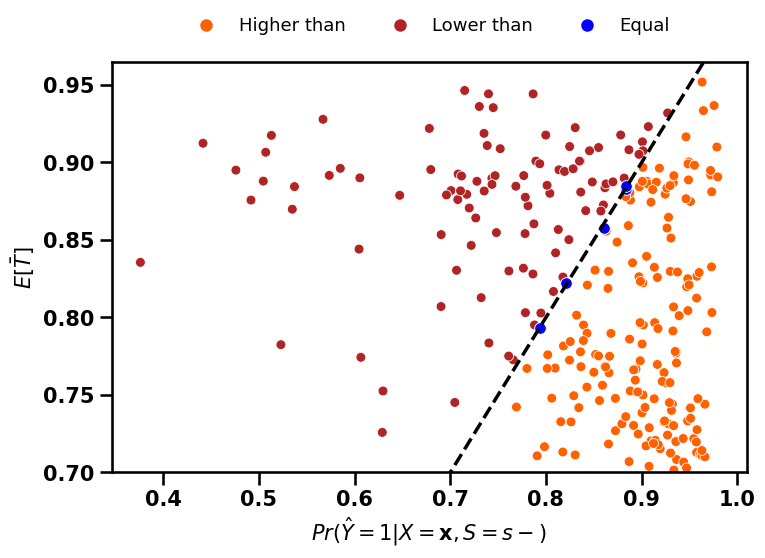

In [78]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 3  
repeat_index = 3 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_043 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_043, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_043 = analysis.full_analysis()

## 4.4 4th experiment

5-fold Cross Validation AUC: [0.85543486 0.84137073 0.81791992 0.83979015 0.8552372 ]
Mean AUC: 0.8419505707462852
Standard Deviation of the Mean AUC: 0.013717407352727778
Standard Error of the Mean AUC: 0.006858703676363888
5-fold Cross Validation Accuracy: [0.81041667 0.83541667 0.81666667 0.83125    0.82291667]
Mean Accuracy: 0.8233333333333335
Standard Deviation of the Mean Accuracy: 0.009166666666666682
Standard Error of the Mean Accuracy: 0.004583333333333341
5-fold Cross Validation Precision: [0.8275     0.85347044 0.83928571 0.85271318 0.83879093]
Mean Precision: 0.8423520523176415
Standard Deviation of the Mean Precision: 0.009732819476548324
Standard Error of the Mean Precision: 0.004866409738274162
5-fold Cross Validation Recall: [0.93767705 0.93785311 0.92937853 0.93220339 0.94067797]
Mean Recall: 0.935558009634929
Standard Deviation of the Mean Recall: 0.004133066786769182
Standard Error of the Mean Recall: 0.002066533393384591
5-fold Cross Validation F1: [0.87915007 0.893

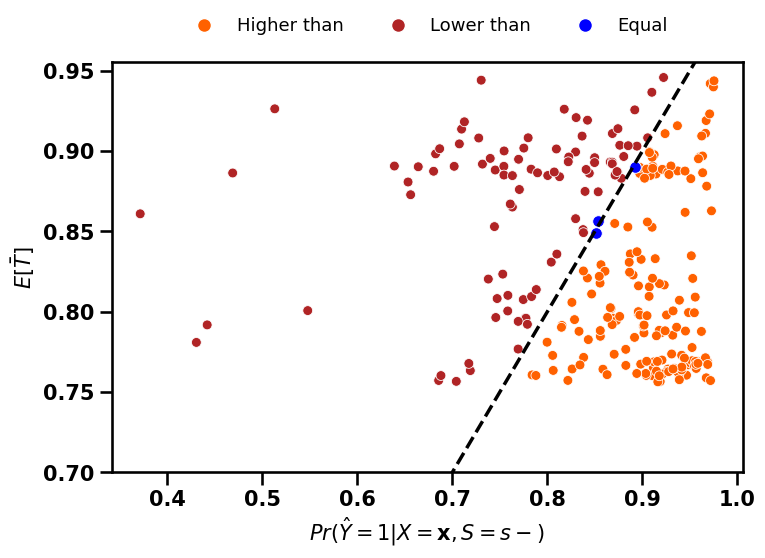

In [79]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 3  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_044 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_044, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_044 = analysis.full_analysis()

## 4.5 5th experiment

5-fold Cross Validation AUC: [0.8328835  0.85668326 0.84745763 0.85962021 0.80956865]
Mean AUC: 0.8412426484012844
Standard Deviation of the Mean AUC: 0.018373301025915084
Standard Error of the Mean AUC: 0.009186650512957542
5-fold Cross Validation Accuracy: [0.81458333 0.84375    0.81666667 0.80416667 0.80625   ]
Mean Accuracy: 0.8170833333333333
Standard Deviation of the Mean Accuracy: 0.014154406459552515
Standard Error of the Mean Accuracy: 0.007077203229776258
5-fold Cross Validation Precision: [0.83333333 0.85316456 0.82281553 0.82828283 0.83375959]
Mean Precision: 0.8342711686703217
Standard Deviation of the Mean Precision: 0.010248835591679262
Standard Error of the Mean Precision: 0.00512441779583963
5-fold Cross Validation Recall: [0.93484419 0.9519774  0.95762712 0.92655367 0.92090395]
Mean Recall: 0.9383812679054433
Standard Deviation of the Mean Recall: 0.014234584655048422
Standard Error of the Mean Recall: 0.007117292327524211
5-fold Cross Validation F1: [0.8811749  0.899

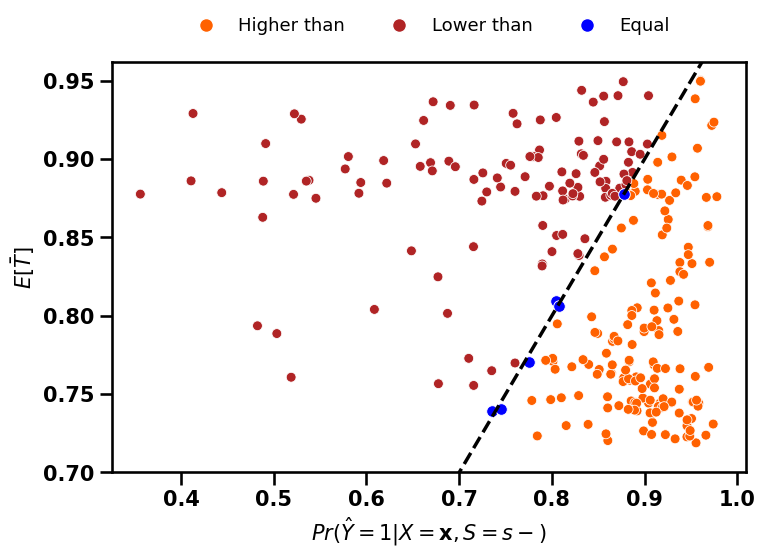

In [80]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 3  
repeat_index = 5 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_045 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_045, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_045 = analysis.full_analysis()

#

# (5) Imbalance level = 31.33%

## 5.1 1st experiment

5-fold Cross Validation AUC: [0.8595483  0.82479798 0.86569697 0.84563636 0.83055556]
Mean AUC: 0.8452470337546849
Standard Deviation of the Mean AUC: 0.015854847939322177
Standard Error of the Mean AUC: 0.007927423969661089
5-fold Cross Validation Accuracy: [0.81458333 0.79791667 0.825      0.79791667 0.81875   ]
Mean Accuracy: 0.8108333333333333
Standard Deviation of the Mean Accuracy: 0.011055415967851293
Standard Error of the Mean Accuracy: 0.0055277079839256464
5-fold Cross Validation Precision: [0.83149171 0.82093664 0.84745763 0.80417755 0.82749326]
Mean Precision: 0.826311357218343
Standard Deviation of the Mean Precision: 0.014100999387660927
Standard Error of the Mean Precision: 0.0070504996938304644
5-fold Cross Validation Recall: [0.91489362 0.9030303  0.90909091 0.93333333 0.93030303]
Mean Recall: 0.9181302385557706
Standard Deviation of the Mean Recall: 0.011827968538534841
Standard Error of the Mean Recall: 0.005913984269267421
5-fold Cross Validation F1: [0.87120116 0.8

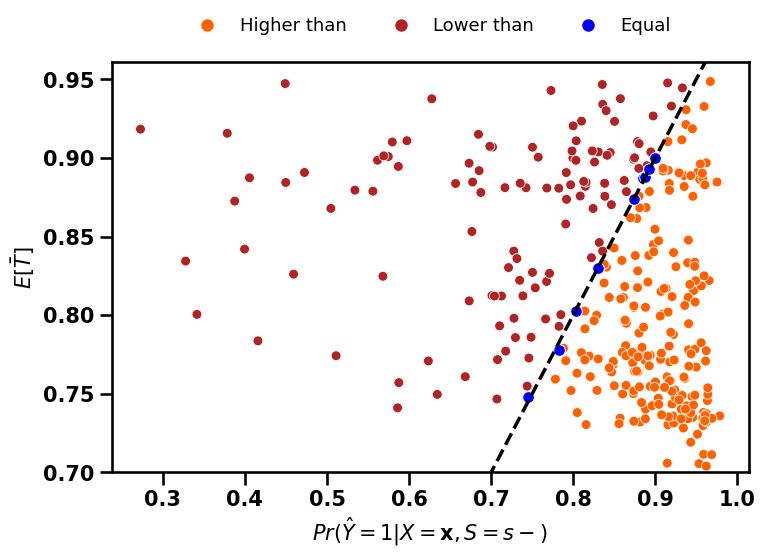

In [81]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 4  
repeat_index = 1 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_051 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_051, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_051 = analysis.full_analysis()

## 5.2 2nd experiment

5-fold Cross Validation AUC: [0.82523803 0.81847475 0.86544444 0.83375758 0.82      ]
Mean AUC: 0.8325829591634862
Standard Deviation of the Mean AUC: 0.017277600812080348
Standard Error of the Mean AUC: 0.008638800406040174
5-fold Cross Validation Accuracy: [0.78958333 0.78541667 0.82291667 0.8        0.775     ]
Mean Accuracy: 0.7945833333333334
Standard Deviation of the Mean Accuracy: 0.016276687487187164
Standard Error of the Mean Accuracy: 0.008138343743593582
5-fold Cross Validation Precision: [0.80481283 0.80266667 0.8470255  0.80789474 0.8       ]
Mean Precision: 0.8124799466968158
Standard Deviation of the Mean Precision: 0.017465699281813657
Standard Error of the Mean Precision: 0.008732849640906828
5-fold Cross Validation Recall: [0.91489362 0.91212121 0.90606061 0.93030303 0.8969697 ]
Mean Recall: 0.9120696324951643
Standard Deviation of the Mean Recall: 0.01099591557121032
Standard Error of the Mean Recall: 0.00549795778560516
5-fold Cross Validation F1: [0.85633001 0.8539

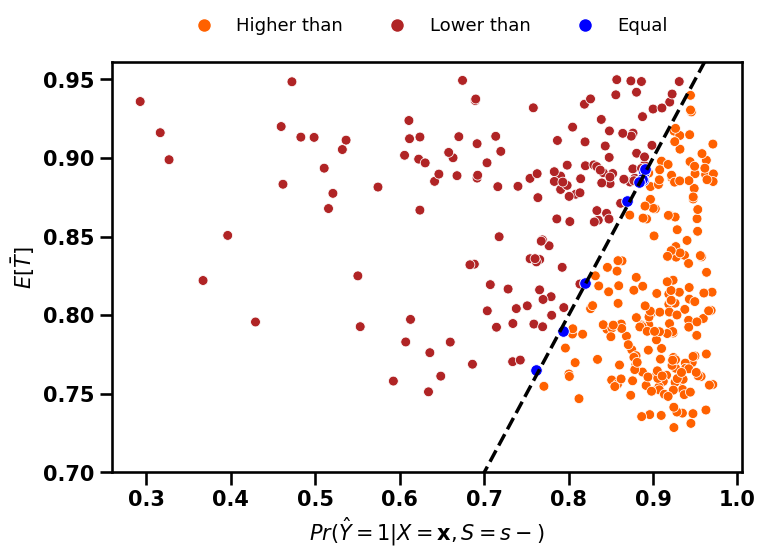

In [82]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 4  
repeat_index = 2 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_052 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_052, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_052 = analysis.full_analysis()

## 5.3 3rd experiment

5-fold Cross Validation AUC: [0.84106967 0.84116162 0.86264646 0.79959596 0.8649596 ]
Mean AUC: 0.8418866607254941
Standard Deviation of the Mean AUC: 0.023464979732008357
Standard Error of the Mean AUC: 0.011732489866004177
5-fold Cross Validation Accuracy: [0.81041667 0.80625    0.83125    0.77291667 0.8375    ]
Mean Accuracy: 0.8116666666666668
Standard Deviation of the Mean Accuracy: 0.022730302828309762
Standard Error of the Mean Accuracy: 0.011365151414154881
5-fold Cross Validation Precision: [0.83240223 0.81769437 0.84487535 0.79310345 0.83870968]
Mean Precision: 0.8253570153131333
Standard Deviation of the Mean Precision: 0.018481897434205995
Standard Error of the Mean Precision: 0.009240948717102997
5-fold Cross Validation Recall: [0.90577508 0.92424242 0.92424242 0.90606061 0.94545455]
Mean Recall: 0.9211550151975683
Standard Deviation of the Mean Recall: 0.014655477318867191
Standard Error of the Mean Recall: 0.007327738659433595
5-fold Cross Validation F1: [0.86754003 0.86

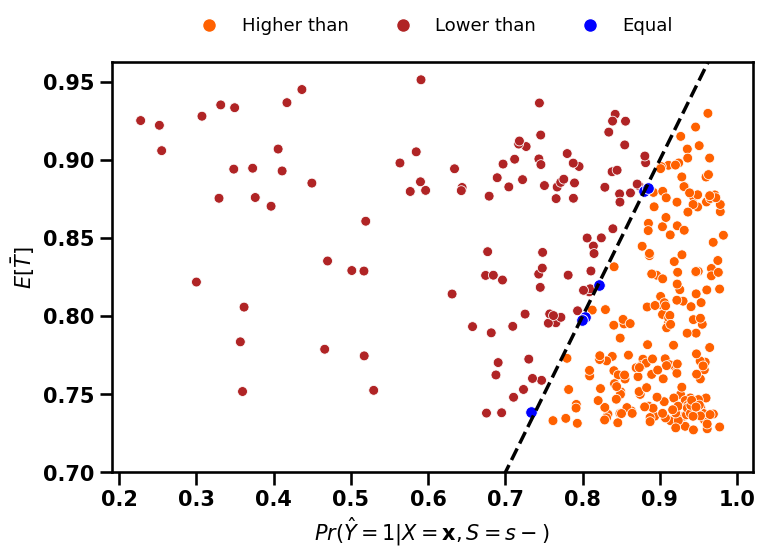

In [83]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 4  
repeat_index = 3 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_053 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_053, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_053 = analysis.full_analysis()

## 5.4 4th experiment

5-fold Cross Validation AUC: [0.83600717 0.83586869 0.84427273 0.85963636 0.85210101]
Mean AUC: 0.8455771907769088
Standard Deviation of the Mean AUC: 0.009249460604334818
Standard Error of the Mean AUC: 0.004624730302167409
5-fold Cross Validation Accuracy: [0.8        0.825      0.80833333 0.8125     0.82916667]
Mean Accuracy: 0.8150000000000001
Standard Deviation of the Mean Accuracy: 0.010736748938937597
Standard Error of the Mean Accuracy: 0.005368374469468798
5-fold Cross Validation Precision: [0.82816901 0.83791209 0.82162162 0.82432432 0.82124352]
Mean Precision: 0.8266541142517208
Standard Deviation of the Mean Precision: 0.00614923230804833
Standard Error of the Mean Precision: 0.003074616154024165
5-fold Cross Validation Recall: [0.89361702 0.92424242 0.92121212 0.92424242 0.96060606]
Mean Recall: 0.9247840103159252
Standard Deviation of the Mean Recall: 0.021297631396409167
Standard Error of the Mean Recall: 0.010648815698204582
5-fold Cross Validation F1: [0.85964912 0.878

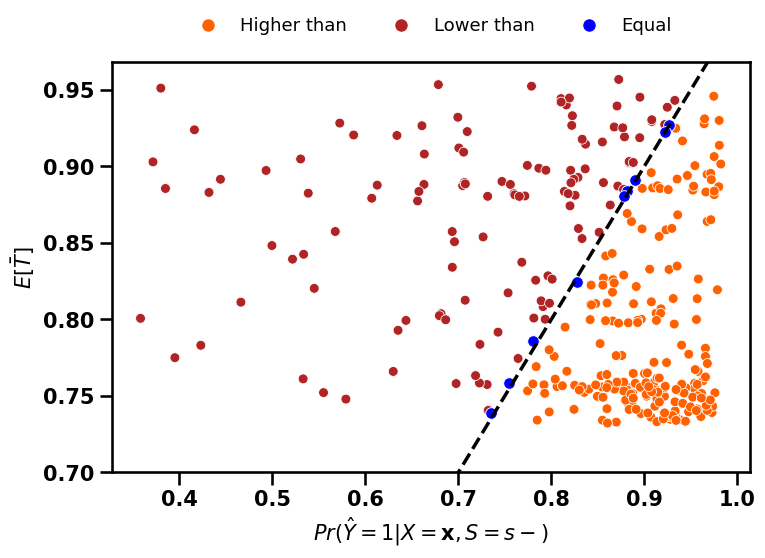

In [84]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 4  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_054 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_054, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_054 = analysis.full_analysis()

## 5.5 5th experiment

5-fold Cross Validation AUC: [0.83600717 0.83586869 0.84427273 0.85963636 0.85210101]
Mean AUC: 0.8455771907769088
Standard Deviation of the Mean AUC: 0.009249460604334818
Standard Error of the Mean AUC: 0.004624730302167409
5-fold Cross Validation Accuracy: [0.8        0.825      0.80833333 0.8125     0.82916667]
Mean Accuracy: 0.8150000000000001
Standard Deviation of the Mean Accuracy: 0.010736748938937597
Standard Error of the Mean Accuracy: 0.005368374469468798
5-fold Cross Validation Precision: [0.82816901 0.83791209 0.82162162 0.82432432 0.82124352]
Mean Precision: 0.8266541142517208
Standard Deviation of the Mean Precision: 0.00614923230804833
Standard Error of the Mean Precision: 0.003074616154024165
5-fold Cross Validation Recall: [0.89361702 0.92424242 0.92121212 0.92424242 0.96060606]
Mean Recall: 0.9247840103159252
Standard Deviation of the Mean Recall: 0.021297631396409167
Standard Error of the Mean Recall: 0.010648815698204582
5-fold Cross Validation F1: [0.85964912 0.878

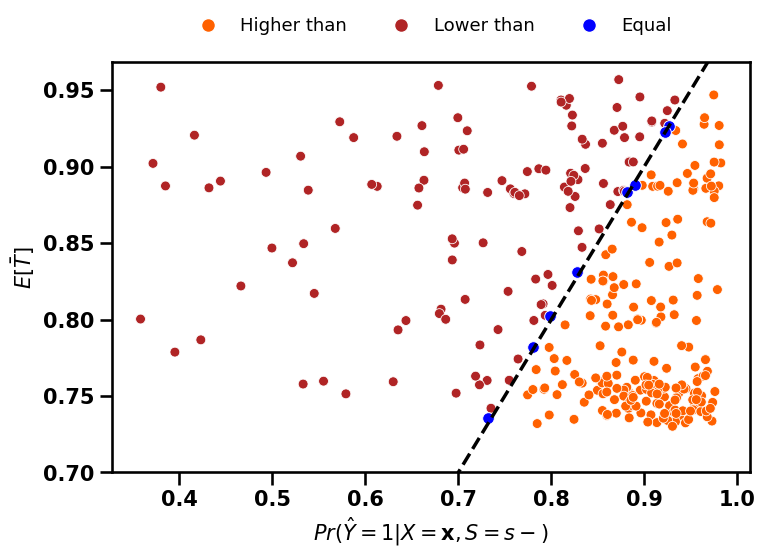

In [85]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 4  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_055 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_055, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_055 = analysis.full_analysis()

#

# (6) Imbalance level = 36.66%

## 6.1 1st experiment

5-fold Cross Validation AUC: [0.86726932 0.83786906 0.81246713 0.81397904 0.84449891]
Mean AUC: 0.8352166919050769
Standard Deviation of the Mean AUC: 0.020440870623580146
Standard Error of the Mean AUC: 0.010220435311790073
5-fold Cross Validation Accuracy: [0.8125     0.7875     0.76041667 0.76041667 0.79583333]
Mean Accuracy: 0.7833333333333333
Standard Deviation of the Mean Accuracy: 0.020369844269300535
Standard Error of the Mean Accuracy: 0.010184922134650267
5-fold Cross Validation Precision: [0.81524927 0.78977273 0.77363897 0.78678679 0.80952381]
Mean Precision: 0.7949943117853738
Standard Deviation of the Mean Precision: 0.015310444858011264
Standard Error of the Mean Precision: 0.007655222429005632
5-fold Cross Validation Recall: [0.91147541 0.90849673 0.88235294 0.85620915 0.88888889]
Mean Recall: 0.8894846244508733
Standard Deviation of the Mean Recall: 0.020017631536620412
Standard Error of the Mean Recall: 0.010008815768310206
5-fold Cross Validation F1: [0.86068111 0.84

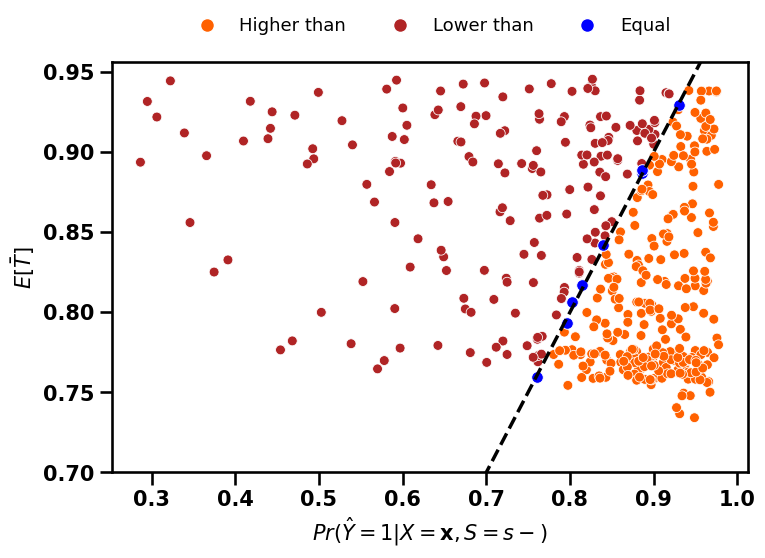

In [86]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 5  
repeat_index = 1 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_061 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_061, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_061 = analysis.full_analysis()

## 6.2 2nd experiment

5-fold Cross Validation AUC: [0.83155035 0.84747577 0.8145237  0.83206558 0.82669409]
Mean AUC: 0.8304618995717122
Standard Deviation of the Mean AUC: 0.01059670635943678
Standard Error of the Mean AUC: 0.00529835317971839
5-fold Cross Validation Accuracy: [0.77708333 0.77708333 0.775      0.77708333 0.78333333]
Mean Accuracy: 0.7779166666666667
Standard Deviation of the Mean Accuracy: 0.0028259708263021852
Standard Error of the Mean Accuracy: 0.0014129854131510924
5-fold Cross Validation Precision: [0.78612717 0.79178886 0.79289941 0.79701493 0.78693182]
Mean Precision: 0.790952435154804
Standard Deviation of the Mean Precision: 0.0040172791758242635
Standard Error of the Mean Precision: 0.0020086395879121313
5-fold Cross Validation Recall: [0.89180328 0.88235294 0.87581699 0.87254902 0.90522876]
Mean Recall: 0.8855501982213652
Standard Deviation of the Mean Recall: 0.011834991421862734
Standard Error of the Mean Recall: 0.005917495710931366
5-fold Cross Validation F1: [0.83563748 0.8

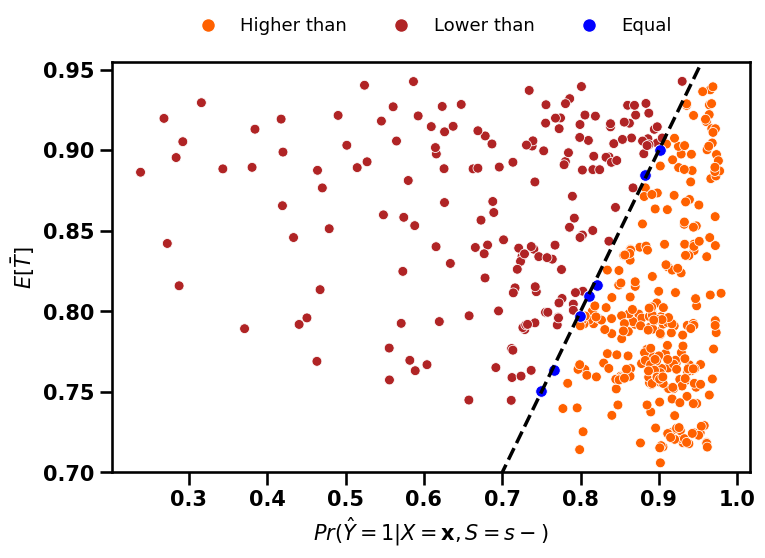

In [87]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 5   
repeat_index = 2 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_062 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_062, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_062 = analysis.full_analysis()

## 6.3 3rd experiment

5-fold Cross Validation AUC: [0.84479625 0.85151379 0.82241191 0.83035647 0.84574788]
Mean AUC: 0.838965260652342
Standard Deviation of the Mean AUC: 0.010822147080714502
Standard Error of the Mean AUC: 0.00541107354035725
5-fold Cross Validation Accuracy: [0.81458333 0.79791667 0.78958333 0.80833333 0.78541667]
Mean Accuracy: 0.7991666666666667
Standard Deviation of the Mean Accuracy: 0.010992421631894107
Standard Error of the Mean Accuracy: 0.0054962108159470535
5-fold Cross Validation Precision: [0.81395349 0.81008902 0.80058651 0.82035928 0.79765396]
Mean Precision: 0.8085284519577887
Standard Deviation of the Mean Precision: 0.008404331709987705
Standard Error of the Mean Precision: 0.0042021658549938525
5-fold Cross Validation Recall: [0.91803279 0.89215686 0.89215686 0.89542484 0.88888889]
Mean Recall: 0.8973320475731276
Standard Deviation of the Mean Recall: 0.010554715214870395
Standard Error of the Mean Recall: 0.005277357607435197
5-fold Cross Validation F1: [0.86286595 0.84

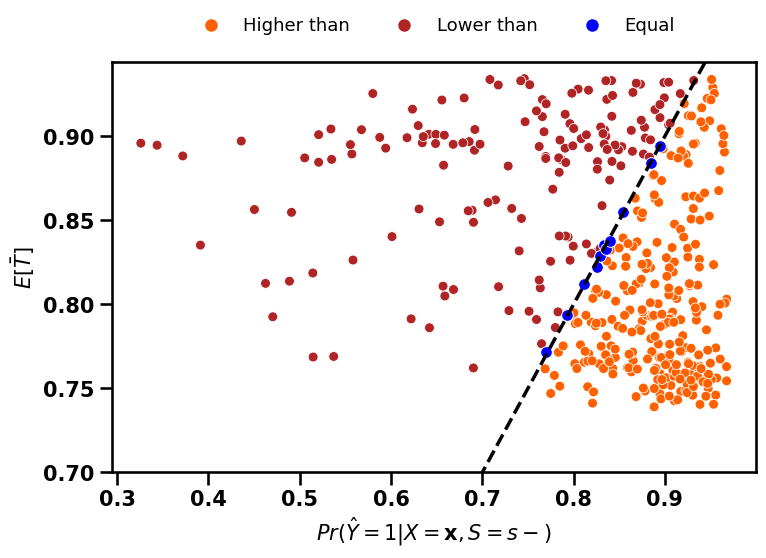

In [88]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 5 
repeat_index = 3 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_063 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_063, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_063 = analysis.full_analysis()

## 6.4 4th experiment

5-fold Cross Validation AUC: [0.82325059 0.85276275 0.84183194 0.83538051 0.80988468]
Mean AUC: 0.8326220951592747
Standard Deviation of the Mean AUC: 0.014851878080550291
Standard Error of the Mean AUC: 0.007425939040275145
5-fold Cross Validation Accuracy: [0.7875     0.79166667 0.77291667 0.79583333 0.7875    ]
Mean Accuracy: 0.7870833333333334
Standard Deviation of the Mean Accuracy: 0.007728015412913058
Standard Error of the Mean Accuracy: 0.0038640077064565296
5-fold Cross Validation Precision: [0.7942029  0.80116959 0.77903683 0.80952381 0.79142857]
Mean Precision: 0.7950723394683696
Standard Deviation of the Mean Precision: 0.010170467890364602
Standard Error of the Mean Precision: 0.005085233945182301
5-fold Cross Validation Recall: [0.89836066 0.89542484 0.89869281 0.88888889 0.90522876]
Mean Recall: 0.8973191899710704
Standard Deviation of the Mean Recall: 0.005295116699414754
Standard Error of the Mean Recall: 0.002647558349707377
5-fold Cross Validation F1: [0.84307692 0.8

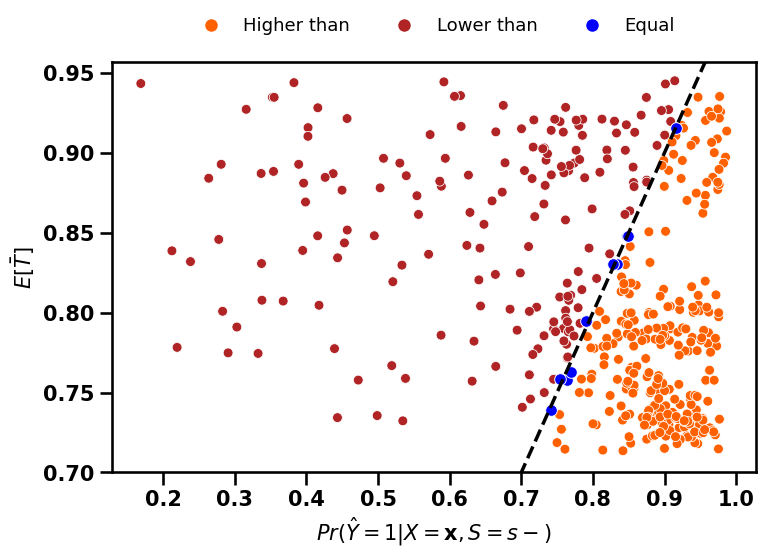

In [89]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 5  
repeat_index = 4 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_064 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_064, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_064 = analysis.full_analysis()

## 6.5 5th experiment

5-fold Cross Validation AUC: [0.82325059 0.85276275 0.84183194 0.83538051 0.80988468]
Mean AUC: 0.8326220951592747
Standard Deviation of the Mean AUC: 0.014851878080550291
Standard Error of the Mean AUC: 0.007425939040275145
5-fold Cross Validation Accuracy: [0.7875     0.79166667 0.77291667 0.79583333 0.7875    ]
Mean Accuracy: 0.7870833333333334
Standard Deviation of the Mean Accuracy: 0.007728015412913058
Standard Error of the Mean Accuracy: 0.0038640077064565296
5-fold Cross Validation Precision: [0.7942029  0.80116959 0.77903683 0.80952381 0.79142857]
Mean Precision: 0.7950723394683696
Standard Deviation of the Mean Precision: 0.010170467890364602
Standard Error of the Mean Precision: 0.005085233945182301
5-fold Cross Validation Recall: [0.89836066 0.89542484 0.89869281 0.88888889 0.90522876]
Mean Recall: 0.8973191899710704
Standard Deviation of the Mean Recall: 0.005295116699414754
Standard Error of the Mean Recall: 0.002647558349707377
5-fold Cross Validation F1: [0.84307692 0.8

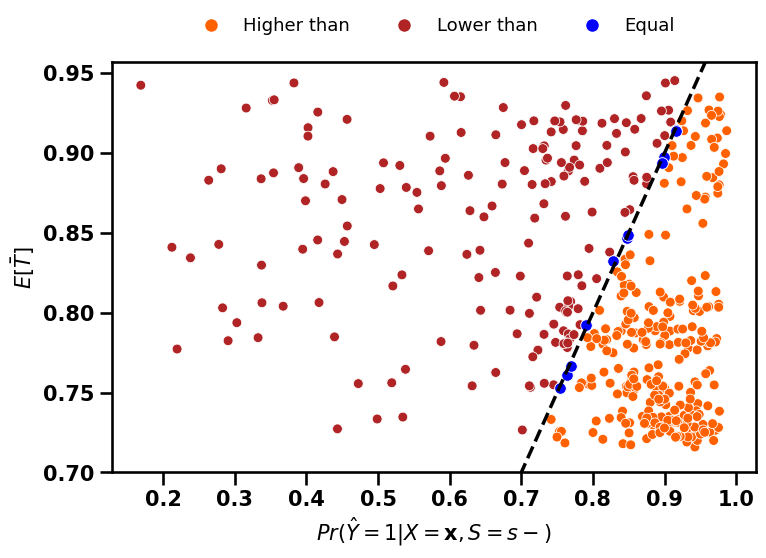

In [90]:
from analysis import automatic_analysis
from analysis.automatic_analysis import AutomatedAnalysis


imbalance_level_index = 5  
repeat_index = 5 
index = (imbalance_level_index * sampler.repeats_per_ratio) + repeat_index - 1

df_065 = sampler.final_adjusted_dfs[index]

nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(df_064, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_065 = analysis.full_analysis()

#

# (7) original imbalance level = 41.33%

5-fold Cross Validation AUC: [0.85975029 0.82159026 0.83752204 0.83786456 0.83608648]
Mean AUC: 0.8385627266060827
Standard Deviation of the Mean AUC: 0.01220393015541242
Standard Error of the Mean AUC: 0.00610196507770621
5-fold Cross Validation Accuracy: [0.79086538 0.76322115 0.76682692 0.765625   0.76052948]
Mean Accuracy: 0.769413588817921
Standard Deviation of the Mean Accuracy: 0.010940725596247904
Standard Error of the Mean Accuracy: 0.005470362798123952
5-fold Cross Validation Precision: [0.79182156 0.78034682 0.7752809  0.76588022 0.75849732]
Mean Precision: 0.7743653630893277
Standard Deviation of the Mean Precision: 0.011533668007870417
Standard Error of the Mean Precision: 0.005766834003935207
5-fold Cross Validation Recall: [0.87295082 0.82991803 0.84836066 0.8647541  0.86885246]
Mean Recall: 0.8569672131147541
Standard Deviation of the Mean Recall: 0.0158940323193978
Standard Error of the Mean Recall: 0.0079470161596989
5-fold Cross Validation F1: [0.83040936 0.80436941 

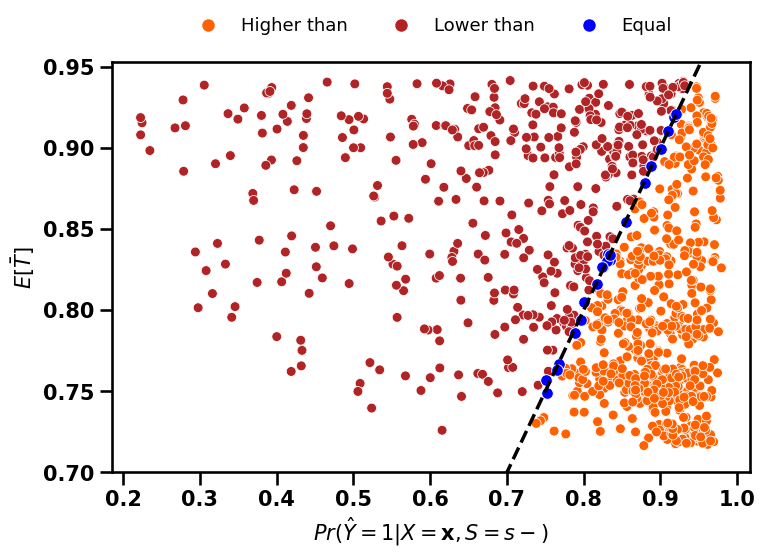

In [91]:
nominals = ['principal', 'legal status']
columns_to_drop = ['gender', 'age','race', 'new gender', 'new age','new race','establish time', 'location', 'new annual turnover','annual turnover','workers number', 'new workers number', 'funds injections']
drop_list = ['final outcomes', 'Binary Y', 'size', 'new size']

analysis = AutomatedAnalysis(merge_df, nominals, columns_to_drop, drop_list, 'new size', 'new size', 'Binary Y', 15, 0.3, 0.05)
results_ori = analysis.full_analysis()

#

# Analysis prepare

In [92]:
from analysis import consistency_table
from analysis.consistency_table import MultiConsistencyCalculator

df11 = results_011['double_sided_results']
df21 = results_021['double_sided_results']
df31 = results_031['double_sided_results']
df41 = results_041['double_sided_results']
df51 = results_051['double_sided_results']
df61 = results_061['double_sided_results']

df12 = results_012['double_sided_results']
df22 = results_022['double_sided_results']
df32 = results_032['double_sided_results']
df42 = results_042['double_sided_results']
df52 = results_052['double_sided_results']
df62 = results_062['double_sided_results']

df13 = results_013['double_sided_results']
df23 = results_023['double_sided_results']
df33 = results_033['double_sided_results']
df43 = results_043['double_sided_results']
df53 = results_053['double_sided_results']
df63 = results_063['double_sided_results']

df14 = results_014['double_sided_results']
df24 = results_024['double_sided_results']
df34 = results_034['double_sided_results']
df44 = results_044['double_sided_results']
df54 = results_054['double_sided_results']
df64 = results_064['double_sided_results']

df15 = results_015['double_sided_results']
df25 = results_025['double_sided_results']
df35 = results_035['double_sided_results']
df45 = results_045['double_sided_results']
df55 = results_055['double_sided_results']
df65 = results_065['double_sided_results']

df7 = results_ori['double_sided_results']

#

# Unfairly treated percentage under each imbalance level

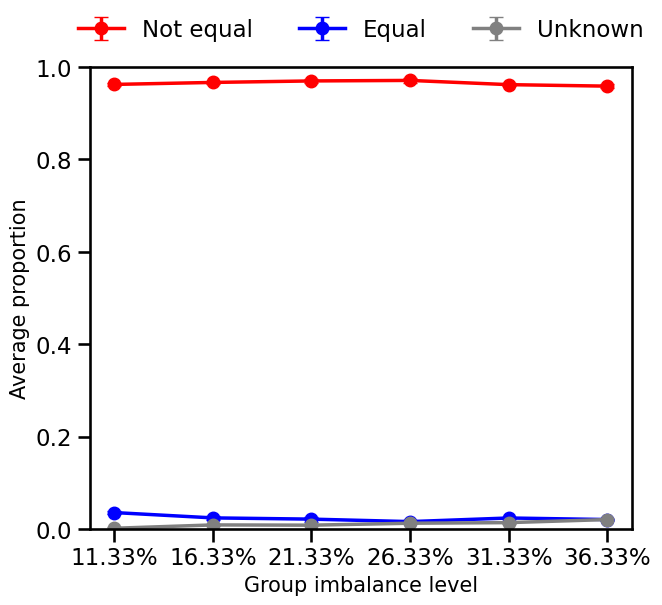

,True_mean,True_stderr,True_prop_1,True_prop_2,True_prop_3,True_prop_4,True_prop_5,False_mean,False_stderr,False_prop_1,...,False_prop_3,False_prop_4,False_prop_5,Unknown_mean,Unknown_stderr,Unknown_prop_1,Unknown_prop_2,Unknown_prop_3,Unknown_prop_4,Unknown_prop_5
11.33%,0.962465,0.003293,0.956522,0.955752,0.964602,0.961538,0.973913,0.035765,0.002835,0.043478,...,0.035398,0.038462,0.026087,0.001770,0.001770,0.000000,0.008850,0.000000,0.000000,0.000000
16.33%,0.966782,0.002655,0.966216,0.972973,0.957576,0.970930,0.966216,0.024225,0.003603,0.020270,...,0.030303,0.023256,0.033784,0.008992,0.002661,0.013514,0.013514,0.012121,0.005814,0.000000
21.33%,0.970014,0.004297,0.972851,0.975490,0.972603,0.953052,0.976077,0.021544,0.005443,0.013575,...,0.022831,0.042254,0.014354,0.008442,0.001711,0.013575,0.009804,0.004566,0.004695,0.009569
26.33%,0.971129,0.004874,0.984962,0.960784,0.964664,0.980695,0.964539,0.016184,0.002908,0.007519,...,0.017668,0.011583,0.021277,0.012687,0.002142,0.007519,0.016340,0.017668,0.007722,0.014184
31.33%,0.961985,0.003599,0.966565,0.961644,0.972892,0.952941,0.955882,0.024017,0.001630,0.027356,...,0.018072,0.026471,0.023529,0.013998,0.002952,0.006079,0.013699,0.009036,0.020588,0.020588
36.33%,0.958753,0.004034,0.965812,0.965812,0.943820,0.960265,0.958057,0.020626,0.001960,0.017094,...,0.024719,0.022075,0.024283,0.020621,0.002733,0.017094,0.019231,0.031461,0.017660,0.017660


In [93]:
from analysis import group_imbalance_bar_error
from analysis.group_imbalance_bar_error import MultiProportionTrend

results = {
    '11.33%': [df11, df12, df13, df14, df15],
    '16.33%': [df21, df22, df23, df24, df25],
    '21.33%': [df31, df32, df33, df34, df35],
    '26.33%': [df41, df42, df43, df44, df45],
    '31.33%': [df51, df52, df53, df54, df55],
    '36.33%': [df61, df62, df63, df64, df65]
}

trend_plotter = MultiProportionTrend(results)
proportions = trend_plotter.calculate_proportions()
summary_stats, summary_df = trend_plotter.calculate_summary_stats(proportions)
trend_plotter.plot_trends()

In [94]:
unfairly_treated_percentage = summary_df[['True_prop_1', 'True_prop_2', 'True_prop_3', 'True_prop_4', 'True_prop_5']]


unfairly_treated_percentage.rename(columns={
    'True_prop_1': 'repeat1',
    'True_prop_2': 'repeat2',
    'True_prop_3': 'repeat3',
    'True_prop_4': 'repeat4',
    'True_prop_5': 'repeat5'
}, inplace=True)

unfairly_treated_percentage=unfairly_treated_percentage.T


mean_values = unfairly_treated_percentage.mean(axis=0)
std_values = unfairly_treated_percentage.std(axis=0)



unfairly_treated_percentage.loc['mean'] = mean_values
unfairly_treated_percentage.loc['std'] = std_values


unfairly_treated_percentage.to_csv('unfairly_treated_percentage.csv', index=True)

unfairly_treated_percentage

C:\Users\s2285280\AppData\Local\Temp\ipykernel_8404\3470362750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unfairly_treated_percentage.rename(columns={


,11.33%,16.33%,21.33%,26.33%,31.33%,36.33%
repeat1,0.956522,0.966216,0.972851,0.984962,0.966565,0.965812
repeat2,0.955752,0.972973,0.975490,0.960784,0.961644,0.965812
repeat3,0.964602,0.957576,0.972603,0.964664,0.972892,0.943820
repeat4,0.961538,0.970930,0.953052,0.980695,0.952941,0.960265
repeat5,0.973913,0.966216,0.976077,0.964539,0.955882,0.958057
mean,0.962465,0.966782,0.970014,0.971129,0.961985,0.958753
std,0.007363,0.005936,0.009607,0.010898,0.008048,0.009020


In [95]:
from analysis import average_consistency_table
from analysis.average_consistency_table import AverageConsistencyCalculator 

calculator1 = MultiConsistencyCalculator([df11, df21, df31, df41, df51, df61, df7])
calculator2 = MultiConsistencyCalculator([df12, df22, df32, df42, df52, df62, df7])
calculator3 = MultiConsistencyCalculator([df13, df23, df33, df43, df53, df63, df7])
calculator4 = MultiConsistencyCalculator([df14, df24, df34, df44, df54, df64, df7])
calculator5 = MultiConsistencyCalculator([df15, df25, df35, df45, df55, df65, df7])

ratios1_df = calculator1.consistency_table()
ratios2_df = calculator2.consistency_table()
ratios3_df = calculator3.consistency_table()
ratios4_df = calculator4.consistency_table()
ratios5_df = calculator5.consistency_table()



calculators = [calculator1, calculator2, calculator3, calculator4, calculator5]

average_calculator = AverageConsistencyCalculator(calculators)

average_ratios_df = average_calculator.average_consistency_table()
cv_ratios_df = average_calculator.cv_consistency_table()

#

# IOR computation

In [96]:
ratios1_last = ratios1_df.iloc[-1, :-1].apply(lambda x: float(x.rstrip('%')) / 100)
ratios2_last = ratios2_df.iloc[-1, :-1].apply(lambda x: float(x.rstrip('%')) / 100)
ratios3_last = ratios3_df.iloc[-1, :-1].apply(lambda x: float(x.rstrip('%')) / 100)
ratios4_last = ratios4_df.iloc[-1, :-1].apply(lambda x: float(x.rstrip('%')) / 100)
ratios5_last = ratios5_df.iloc[-1, :-1].apply(lambda x: float(x.rstrip('%')) / 100)

consistency_df = pd.DataFrame({
    'repeat1': ratios1_last,
    'repeat2': ratios2_last,
    'repeat3': ratios3_last,
    'repeat4': ratios4_last,
    'repeat5': ratios5_last
})

consistency_df = consistency_df.T
consistency_df.columns = ['11.33%', '16.33%', '21.33%', '26.33%', '31.33%', '36.33%']

mean_values = consistency_df.mean(axis=0)
std_values = consistency_df.std(axis=0)

consistency_df.loc['mean'] = mean_values
consistency_df.loc['std'] = std_values

consistency_df.to_csv('invariance_outcomes_ratio.csv', index=True)

consistency_df

,11.33%,16.33%,21.33%,26.33%,31.33%,36.33%
repeat1,0.905700,0.967000,0.983500,0.958900,0.966900,0.960300
repeat2,0.940300,0.978000,0.981500,0.933700,0.962100,0.973900
repeat3,0.933300,0.940500,0.944900,0.955700,0.977000,0.958800
repeat4,0.967200,0.951000,0.941700,0.970800,0.937500,0.957700
repeat5,0.983300,0.936700,0.956500,0.959200,0.937500,0.953800
mean,0.945960,0.954640,0.961620,0.955660,0.956200,0.960900
std,0.030243,0.017561,0.019853,0.013551,0.017898,0.007655


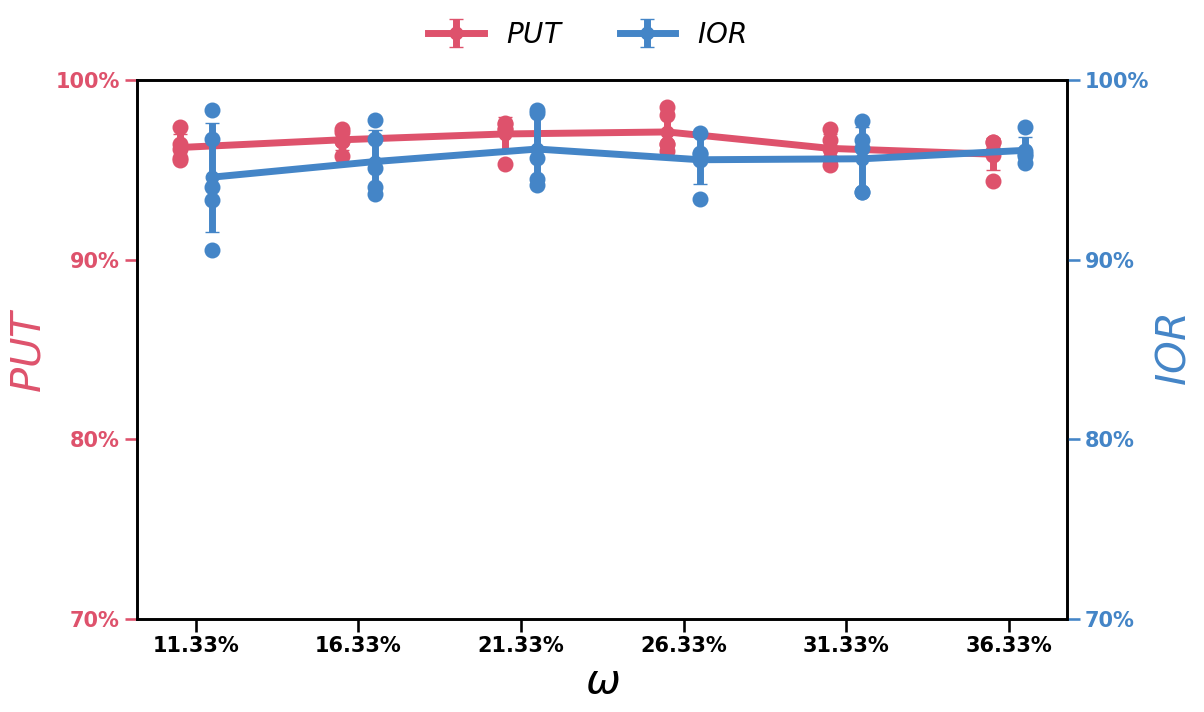

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

means1 = unfairly_treated_percentage.loc['mean']
stderr1 = unfairly_treated_percentage.loc['std']

means2 = consistency_df.loc['mean']
stderr2 = consistency_df.loc['std']

# x: imbalance level
x_ticks = np.array([11.33, 16.33, 21.33, 26.33, 31.33, 36.33])


fig, ax1 = plt.subplots(figsize=(12,7))

# plot the first line
color1 = '#DE526C'
means1 = unfairly_treated_percentage.loc['mean']
stderr1 = unfairly_treated_percentage.loc['std']
ax1.errorbar(x_ticks - 0.5, means1, yerr=stderr1, fmt='-o', capsize=5, label='$PUT$', color=color1, linewidth=5)
for i, xtick in enumerate(x_ticks):
    ax1.scatter([xtick - 0.5]*5, unfairly_treated_percentage.iloc[:5, i], color=color1, s=100)  # 添加数据点
ax1.set_xlabel('$\omega$', fontsize=30)
ax1.set_ylabel('$PUT$', fontsize=30, color=color1)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=15, colors=color1)

# plot the second line
color2 = '#4485C7'
means2 = consistency_df.loc['mean']
stderr2 = consistency_df.loc['std']
ax2 = ax1.twinx()
ax2.errorbar(x_ticks + 0.5, means2, yerr=stderr2, fmt='-o', capsize=5, label='$IOR$', color=color2, linewidth=5)
for i, xtick in enumerate(x_ticks):
    ax2.scatter([xtick + 0.5]*5, consistency_df.iloc[:5, i], color=color2, s=100)  # 添加数据点
ax2.set_ylabel('$IOR$', fontsize=30, color=color2)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=15, colors=color2)


ax1.set_ylim(0.7, 1)
ax2.set_ylim(0.7, 1)


ax1.set_yticks(np.arange(0.7, 1.09, 0.1))
ax2.set_yticks(np.arange(0.7, 1.09, 0.1))


ax1.set_xticks(x_ticks)
ax1.set_xticklabels([f'{tick}%' for tick in x_ticks], fontsize=15)


ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))


for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontweight('bold')
            


fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=3, frameon=False, fontsize=20)


plt.savefig('combined_proportion_trend_with_error_bars.pdf', format='pdf', dpi=300)
plt.show()

#

# Alternative pair-wise IOR computation

In [99]:
from analysis import average_consistency_table
from analysis.average_consistency_table import AverageConsistencyCalculator 

calculator1 = MultiConsistencyCalculator([df11, df21, df31, df41, df51, df61])
calculator2 = MultiConsistencyCalculator([df12, df22, df32, df42, df52, df62])
calculator3 = MultiConsistencyCalculator([df13, df23, df33, df43, df53, df63])
calculator4 = MultiConsistencyCalculator([df14, df24, df34, df44, df54, df64])
calculator5 = MultiConsistencyCalculator([df15, df25, df35, df45, df55, df65])

ratios1_df = calculator1.consistency_table()
ratios2_df = calculator2.consistency_table()
ratios3_df = calculator3.consistency_table()
ratios4_df = calculator4.consistency_table()
ratios5_df = calculator5.consistency_table()


calculators = [calculator1, calculator2, calculator3, calculator4, calculator5]

average_calculator = AverageConsistencyCalculator(calculators)

average_ratios_df = average_calculator.average_consistency_table()
cv_ratios_df = average_calculator.cv_consistency_table()

In [100]:
average_ratios_df

,df1,df2,df3,df4,df5,df6
df1,nan%,nan%,nan%,nan%,nan%,nan%
df2,93.57%,nan%,nan%,nan%,nan%,nan%
df3,93.78%,96.65%,nan%,nan%,nan%,nan%
df4,96.34%,94.70%,96.23%,nan%,nan%,nan%
df5,95.82%,94.93%,94.95%,96.17%,nan%,nan%
df6,92.67%,95.41%,95.95%,95.92%,95.24%,nan%


C:\Users\s2285280\fairness-credit-scoring\group_imbalance\size_caplier\../..\analysis\average_consistency_table.py:133: RuntimeWarning: Mean of empty slice
  means = np.nanmean(row_values, axis=0)
C:\Users\s2285280\AppData\Local\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


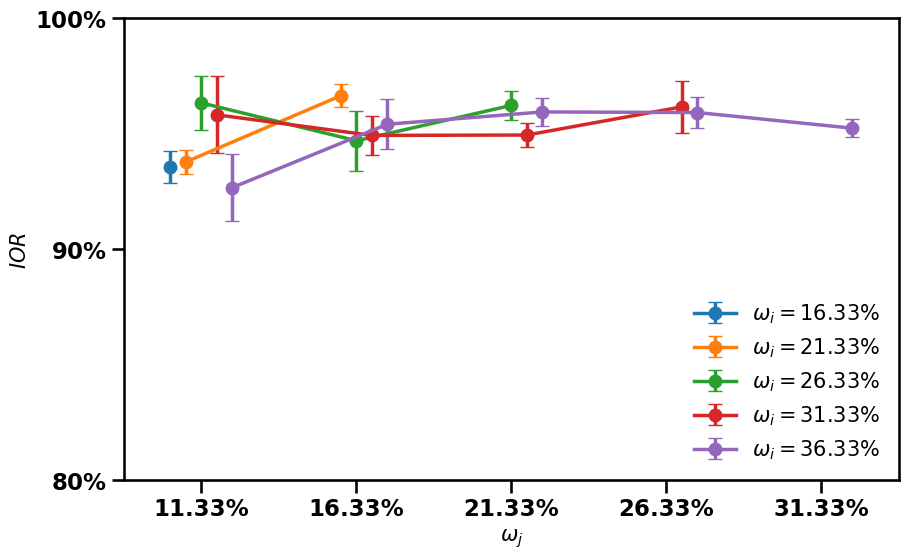

In [101]:
from analysis import average_consistency_table
from analysis.average_consistency_table import RatioLinePlotter

dataframes = [ratios1_df, ratios2_df, ratios3_df, ratios4_df, ratios5_df]
plotter = RatioLinePlotter(*dataframes)
plotter.plot()